In [1]:
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import random
import os
os.chdir('images')

In [2]:
def get_mask(file):
    mask = plt.imread(file)
    w, h = mask.shape
    d = {}
    for i in range(h):
        for j in range(w):
            d[(i,j)] = False if mask[i,j] < 128 else True
    return mask, d

def get_rand(d, r, nr):
    all_river = list(filter(lambda k: d[k] != 0, d))
    all_non_river = list(filter(lambda k: d[k] == 0, d))
    
    river = random.sample(all_river, r)
    non_river = random.sample(all_non_river, nr)
    
    return np.array(river), np.array(non_river)

def get_data(idxs, r='1.gif', g='2.gif', b='3.gif', i='4.gif'):
    R, G, B, I = plt.imread(r), plt.imread(g), plt.imread(b), plt.imread(i)
    data = []
    for idx in idxs:
        point = tuple([R[idx[0]][idx[1]][0], G[idx[0]][idx[1]][0], B[idx[0]][idx[1]][0], I[idx[0]][idx[1]][0]])
        data.append(point)
    return np.array(data)

In [16]:
class Naive_Bayes:
    
    def __init__(self):
        pass
    
    def train(self, river, non_river):
        self.Tr = np.mean(river, axis=0)
        self.Tnr = np.mean(non_river, axis=0)
        self.cov_r = np.cov(river.T)
        self.cov_nr = np.cov(non_river.T)
        dev_r = river - self.Tr
        dev_nr = river - self.Tnr
        
    def test(self, X, P1, P2):
        Y = []
        for x in tqdm(X):
            dev_r = x - self.Tr
            dev_nr = x - self.Tnr
            river_class = dev_r.T.dot(np.linalg.inv(self.cov_r)).dot(dev_r)
            non_river_class = dev_nr.T.dot(np.linalg.inv(self.cov_nr)).dot(dev_nr)
            
            p1 = -.5 * 1/np.sqrt(np.linalg.det(self.cov_r)) * np.exp(river_class)
            p2 = -.5 * 1/np.sqrt(np.linalg.det(self.cov_nr)) * np.exp(non_river_class)
            
            Y.append(P1 * p1 >= P2 * p2)
            
        return np.array(Y)        

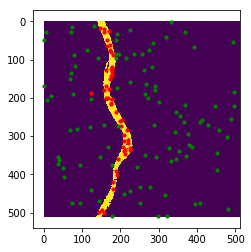

In [4]:
image, d = get_mask('UDCV3.jpeg')
river_idx, non_river_idx = get_rand(d, 50, 100)
river = get_data(river_idx)
non_river = get_data(non_river_idx)
plt.imshow(image)
plt.scatter(x=list(map(lambda p: p[1], river_idx)), y=list(map(lambda p: p[0], river_idx)), c='r', s=10)
plt.scatter(x=list(map(lambda p: p[1], non_river_idx)), y=list(map(lambda p: p[0], non_river_idx)), c='g', s=10)
plt.show()

In [17]:
model = Naive_Bayes()
model.train(river, non_river)
data = get_data(list(d.keys()))
yy = model.test(data, .7, .3)
y = list(d.values())

/home/dedsec/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in double_scalars


Accuracy: 0.9970970153808594


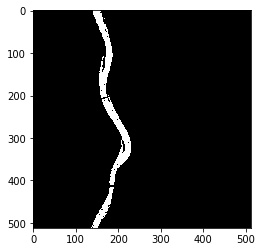

In [18]:
count_wrong = lambda test_y,yy: sum([a != b for a,b in zip(test_y, yy)])
num_errs = count_wrong(yy, y)
print('Accuracy: {}'.format(1-num_errs/len(yy)))
result = Image.fromarray(yy.reshape(image.shape).astype('uint8')*255)
plt.imshow(result)
plt.show()
result.save('result2.png')